# Wordle solver
We need to make some assumptions to write an explicit solution, such as:

* Words are likely to be the solution proportional to their use in the corpus
  * In reality, there may be a non-linear relationship, e.g. square root
  * **My intuition is to use metric `letter_freq += 1 + math.sqrt(word_frequency)`** for each occurence of letter
* Based on the above, letters are likely to be in the solution proportional to their (weighted) use in the corpus
* Getting a "green" is more valuable than getting a "yellow" (take letter frequency at individual positions into account)
* etc.

A better solution may be to use reinforcement learning, so as to avoid making these assumptions.

In [93]:
import pandas as pd
import numpy as np
import string
from collections import defaultdict
import math

In [94]:
print('Preparing vocabulary...')

Preparing vocabulary...


In [95]:
# https://www.kaggle.com/datasets/rtatman/english-word-frequency?resource=download
words = pd.read_csv('./data/unigram_freq.csv')
az = string.ascii_lowercase

In [96]:
# Filter to 5 letter words
words = words[words['word'].str.len() == 5]
words['freq'] = words['count'] / words['count'].max()
print(len(words))
words.head()

39933


,word,count,freq
35,about,1226734006,1.000000
45,other,978481319,0.797631
56,which,810514085,0.660709
57,their,782849411,0.638157
62,there,701170205,0.571575


In [97]:
# Allowable wordle words
# https://github.com/tabatkins/wordle-list
allowed_words = pd.read_csv('./data/wordle-allowed-words.txt', header=None)
print(len(allowed_words))
allowed_words.head()

12947


,0
0,women
1,nikau
2,swack
3,feens
4,fyles


In [98]:
# Filter word frequency table to include allowed words only
words = words[words['word'].isin(set(allowed_words[0]))]
len(words)

8072

In [99]:
# Add the other allowed words but with count and freq 0
counted_words = set(words['word'])
new_rows = []
for w in allowed_words[0]:
    if w not in counted_words:
        new_row = {'word': w, 'count':0, 'freq':0}
        new_rows.append(new_row)

words = words.append(pd.DataFrame(new_rows))

In [100]:
# Load Wordle solutions (test set)
# https://medium.com/@owenyin/here-lies-wordle-2021-2027-full-answer-list-52017ee99e86
solutions = pd.read_csv('./data/wordle_solutions.txt', sep=' ', header=None)
solutions = list(solutions[5].str.lower())

## 1. Find "best" words

In [101]:
# Letter frequency
letter_freq = defaultdict(int)
for _, w in words.iterrows():
    for char in w['word']:
#         Many ways to weight this:
#         letter_freq[char] += w['freq']
#         letter_freq[char] += 1
        letter_freq[char] += 1 + math.sqrt(w['freq'])

sorted_letters = sorted(letter_freq.items(), key=lambda x: -x[1])
sorted_letters[:5]

[('e', 6826.373093957733),
 ('s', 6797.120446066696),
 ('a', 6115.552312164332),
 ('o', 4536.092041527143),
 ('r', 4266.03717813045)]

In [102]:
# Find the best "starting words"
# Best: maximizing total letter_freq (but 0 score for repeated letter)
# This doesn't take into account letter position
word_goodness = defaultdict(float)
for w in allowed_words[0]:
    used_chars = set()
    for char in w:
        if char in used_chars:
            continue
        word_goodness[w] += letter_freq[char]
        used_chars.add(char)
        
sorted_words = sorted(word_goodness.items(), key=lambda x: -x[1])
sorted_words[:5]

[('arose', 28541.175071846355),
 ('soare', 28541.17507184635),
 ('aeros', 28541.17507184635),
 ('raise', 27847.75322556465),
 ('serai', 27847.75322556465)]

In [103]:
# Take letter position into account
# Letter frequency per position
letter_pos_freq = [defaultdict(float) for _ in range(5)]
for _, w in words.iterrows():
    for i, char in enumerate(w['word']):
#         Many ways to weight this:
#         letter_freq[char] += w['freq']
#         letter_freq[char] += 1
        letter_pos_freq[i][char] += 1 + math.sqrt(w['freq'])

sorted_pos_letters = [sorted(letter_pos_freq[i].items(), key=lambda x: -x[1]) for i in range(5)]
[s[0] for s in sorted_pos_letters]

[('s', 1599.4231123478824),
 ('a', 2308.278555858041),
 ('a', 1272.652282524225),
 ('e', 2382.654624241403),
 ('s', 4028.057199519846)]

In [104]:
# Find the best "starting words"
# Best: maximizing total letter_freq (but 0 score for repeated letter)
# This doesn't take into account letter position
word_goodness_pos = defaultdict(float)
for w in allowed_words[0]:
    used_chars = set()
    for i, char in enumerate(w):
#         if char in used_chars:
#             continue
        word_goodness_pos[w] += letter_pos_freq[i][char]
        used_chars.add(char)
        
sorted_words_pos = sorted(word_goodness_pos.items(), key=lambda x: -x[1])
sorted_words_pos[:5]

[('sores', 11378.663564416172),
 ('sanes', 11302.442739774659),
 ('sales', 11184.413237562803),
 ('sones', 11139.699481722342),
 ('soles', 11021.669979510487)]

In [105]:
word_good_df = pd.DataFrame(dict(word_goodness), index=['']).T
word_good_df.columns = ['overall']

In [106]:
word_good_df_pos = pd.DataFrame(dict(word_goodness_pos), index=['']).T
word_good_df_pos.columns = ['position']

In [107]:
word_good_df_all = word_good_df.join(word_good_df_pos)
word_good_df_all['avg'] = (
    (word_good_df_all['overall'] / word_good_df_all['overall'].max())
    + (word_good_df_all['position'] / word_good_df_all['position'].max())
) / 2
best_words = word_good_df_all.sort_values(['avg'], ascending=False)
best_words.head()

,overall,position,avg
tares,27396.857394,10781.425154,0.953709
lares,27460.499011,10532.511384,0.943887
cares,26082.927054,10887.691356,0.935361
pares,26061.732612,10820.055129,0.932017
dares,26511.353264,10636.135606,0.931812


## 2. Solver (hard mode)
This will always use existing clues. Note that this is not an optimal strategy for playing not in hard mode - where using a completely different set of letters is preferred for more information gain.

We can define a set of allowable letters for each position, which is initially all letters, then narrows.

Start by doing an example.

In [108]:
best_word_list = best_words.index
best_word_array = np.array([np.array([c for c in w]) for w in best_word_list])

def use_clues(word, result):
    # Special case: Same letter is green and grey
    # Have to keep track of position of green chars
    green_idx = defaultdict(list)
    grey = set()
    for i, r in enumerate(result):
        char = word[i]
        if r == 'grey':
            grey.add(char)
        elif r == 'green':
            green_idx[char].append(i)
    green_and_grey = set(green_idx.keys()).intersection(grey)
    for i, r in enumerate(result):
        char = word[i]
        if r == 'green':
            a[i] = set([char])
        elif r == 'yellow':
            try:
                a[i].remove(char)
            except:
                continue
            b.add(char)
        elif r == 'grey':
            if char in green_and_grey:
                # Remove this option from all but the green positions
                for i, pos in enumerate(a):
                    if i in green_idx[char]:
                        continue
                    try:
                        pos.remove(char)
                    except:
                        continue
            else:
                # Remove from all positions
                for pos in a:
                    try:
                        pos.remove(char)
                    except:
                        continue

# Find all allowable words matching the constraints
def find_ok_words(a, b):
    a_met = (
        np.in1d(best_word_array[:,0], list(a[0]))
        & np.in1d(best_word_array[:,1], list(a[1]))
        & np.in1d(best_word_array[:,2], list(a[2]))
        & np.in1d(best_word_array[:,3], list(a[3]))
        & np.in1d(best_word_array[:,4], list(a[4]))
    )
#     print('meets a:', a_met.sum())
    if len(b) > 0:
        b_met_each = []
        for char in b:
            b_met_each.append(np.array([char in word for word in best_word_list]))
        b_met_all = np.array([True] * len(best_word_list))
        for b_met in b_met_each:
            b_met_all = b_met_all & b_met
    else:
        b_met_all = np.array([True] * len(best_word_list))
#     print('meets b:', b_met_all.sum())
    ok_words = best_word_array[a_met & b_met_all]
    return [''.join(w) for w in ok_words]

# Find the best clue word (most information)
def find_clue(a, b):
    ok_words = find_ok_words(a, b)
    # ok_words is already ranked by how useful the letters are
    return ok_words[0]

# Find the most likely solution word (most common)
def find_solution(a, b):
    ok_words = find_ok_words(a, b)
    print(len(ok_words), 'matching words.')
    # Get the most common word in ok_words
    ok_words_sorted = words[words['word'].isin(ok_words)]
    return ok_words_sorted['word'].values[0]

def find_clues_solutions(a, b, guess_num, verbose=False):
    ok_words = find_ok_words(a, b)
    
    print()
    print(len(ok_words), 'valid words.')
    
    # Get the most common word in ok_words
    most_common_words = words[words['word'].isin(ok_words)]
    most_common_words.index = most_common_words['word']
    most_common_words = most_common_words[['freq']]
    most_common_words.columns = ['Word Frequency']
    most_common_words.index.name = None
        
    best_info_words = best_words.loc[ok_words][['avg']]
    best_info_words.columns = ['Information Gain']
        
    best_of_both = best_info_words.join(most_common_words)
    
#     if guess_num < 2:
#         print('\nRecommended word (best information gain):')
#         print(best_info_words.index[0])
#     elif guess_num < 5:
#         print('\nRecommended word (best combination of information gain and word frequency):')
#         print(best_of_both.index[0])
#     else:
#         print('\nRecommended word (most common word matching constraints):')
#         print(most_common_words.index[0])

    # New way: take a weighted average of the rank of each
    best_of_both['word'] = best_of_both.index
    best_of_both = best_of_both.sort_values(['Information Gain']).reset_index().drop(['index'],axis=1)
    best_of_both['info_idx'] = best_of_both.index
    best_of_both = best_of_both.sort_values(['Word Frequency']).reset_index().drop(['index'],axis=1)
    best_of_both['freq_idx'] = best_of_both.index
    best_of_both.index = best_of_both['word']

    freq_weight = 0.2 * guess_num
    info_weight = 1 - freq_weight
    
    best_of_both['Combined Score'] = best_of_both['info_idx']*info_weight + best_of_both['freq_idx']*freq_weight
    best_of_both = best_of_both.sort_values(['Combined Score'], ascending=False)
    
    if verbose == True:
        print('\nFrequent letters in common positions):')
        print(best_info_words.head())
        print('\nMost common words:')
        print(most_common_words.head())
        print(f'\nWeighted combination (w_info={info_weight}, w_freq={freq_weight}):')
        print(best_of_both[['Combined Score', 'Information Gain', 'Word Frequency']].head(5))
        
    print('\nRecommended word:')
    print(best_of_both.index[0])
    print()
    return best_of_both.index[0]
    
# Shorthands to make entering results easier
sh = ['grey', 'yellow', 'green']

In [110]:
verbose = False
auto_mode = True

while True:
    # Allowed letters
    a = [set(az) for _ in range(5)]
    # Necessary letters
    b = set()
    
    quit = False
    print('\n=============\n')
    print('\nWORDLE SOLVER')
    word = find_clues_solutions(a, b, 0, verbose=verbose)
    print()
    for i in range(1, 7):
        if not auto_mode:
            word = input(f'Guess {i} (or type "exit", "restart"): ')
        else:
            print(f"Enter the word ({word}) in Wordle now.")
        if word == 'restart':
            break
        elif word == 'exit':
            quit = True
            break
        result = input('Result? (0=grey, 1=yellow, 2=green): ')
        result = [sh[int(s)] for s in result]
        use_clues(word, result)
#         print('Best solution word is:', find_solution(a, b))
#         print('Best clue word is:', find_clue(a,b))
        try:
            word = find_clues_solutions(a, b, i, verbose=verbose)
        except:
            print('Impossible! Restarting.')
            break
        print('')
        
    if quit:
        break




WORDLE SOLVER

12947 valid words.

Recommended word:
tares


Enter the word (tares) in Wordle now.
Result? (0=grey, 1=yellow, 2=green): exit


ValueError: invalid literal for int() with base 10: 'e'

## Test the solver against Wordle solutions

In [ ]:
def test_guess(guess, solution):
    assert len(solution) == 5
    assert len(guess) == 5
    response = ''
    for i in range(5):
        # Green
        if guess[i] == solution[i]:
            response += '2'
        elif guess[i] in solution:
            response += '1'
        else:
            response += '0'
    print(response)
    return [sh[int(s)] for s in response]
    
def test_solver(solution, a, b, verbose=False):
    assert len(solution) == 5
    guess = None
    i = 0
    while i < 10:
        i += 1
        guess = find_clues_solutions(a, b, i-1, verbose=verbose)
        if guess == solution:
            print(f'Solved in {i} guesses.')
            return i
        result = test_guess(guess, solution)
        use_clues(guess, result)
    return 10

In [156]:
solution_test_results = dict()
for solution in solutions:
    a = [set(az) for _ in range(5)]
    b = set()
    try:
        solution_test_results[solution] = test_solver(solution, a, b)
    except:
        solution_test_results[solution] = 0


12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00110

36 valid words.

Recommended word:
pilar

02022

4 valid words.

Recommended word:
cigar

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10110

54 valid words.

Recommended word:
route

20111

2 valid words.

Recommended word:
recut

22022

1 valid words.

Recommended word:
rebut

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20010

26 valid words.

Recommended word:
shiny

20102

3 valid words.

Recommended word:
sissy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00100

67 valid words.

Recommended word:
bunny

02000

8 valid words.

Recommended word:
gummi

02210

1 valid words.

Recommended word:
humph

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

20


12947 valid words.

Recommended word:
tares

00020

419 valid words.

Recommended word:
money

00120

39 valid words.

Recommended word:
widen

00121

6 valid words.

Recommended word:
nuked

11022

3 valid words.

Recommended word:
unfed

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

10001

34 valid words.

Recommended word:
blend

01200

6 valid words.

Recommended word:
whelp

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

21100

29 valid words.

Recommended word:
tolar

20111

2 valid words.

Recommended word:
trail

22202

1 valid words.

Recommended word:
trawl

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

01001

9 valid words.

Recommended word:
cloth

00110

3 valid words.

Recommended word:
outdo

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

202


1 valid words.

Recommended word:
delta

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

10010

11 valid words.

Recommended word:
linch

11020

2 valid words.

Recommended word:
flick

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

20020

41 valid words.

Recommended word:
toney

22020

11 valid words.

Recommended word:
toped

22020

2 valid words.

Recommended word:
towel

22020

1 valid words.

Recommended word:
totem

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10020

105 valid words.

Recommended word:
poker

02022

27 valid words.

Recommended word:
homer

02022

17 valid words.

Recommended word:
cover

02022

11 valid words.

Recommended word:
boxer

02022

8 valid words.

Recommended word:
dozer

02022

4 valid words.

Recommended word:
goner

02022

2 valid words.

Recommended word:
fouer

02022

1 valid words.

Re

Recommended word:
watch

02222

4 valid words.

Recommended word:
catch

12222

3 valid words.

Recommended word:
batch

02222

2 valid words.

Recommended word:
hatch

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10021

16 valid words.

Recommended word:
buyer

00122

3 valid words.

Recommended word:
yoker

10022

2 valid words.

Recommended word:
hyper

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

20000

80 valid words.

Recommended word:
tonic

20000

9 valid words.

Recommended word:
tummy

21120

2 valid words.

Recommended word:
thumb

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

12001

3 valid words.

Recommended word:
dolor

22011

2 valid words.

Recommended word:
dobro

22021

1 valid words.

Recommended word:
dowry

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Reco

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

12020

37 valid words.

Recommended word:
diner

02222

5 valid words.

Recommended word:
miner

02222

4 valid words.

Recommended word:
finer

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00221

20 valid words.

Recommended word:
sorel

20220

15 valid words.

Recommended word:
siren

20220

11 valid words.

Recommended word:
shred

20220

6 valid words.

Recommended word:
spree

20221

3 valid words.

Recommended word:
screw

20220

2 valid words.

Recommended word:
surer

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

02100

92 valid words.

Recommended word:
dairy

12110

7 valid words.

Recommended word:
radio

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

22002

7 valid words.

Recommended word:
roule

22202

1 valid words.

Recommended word:
rouge

Solved in 4 guesses.

129


2 valid words.

Recommended word:
acute

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00210

100 valid words.

Recommended word:
borne

00201

29 valid words.

Recommended word:
peril

02200

12 valid words.

Recommended word:
mercy

02202

8 valid words.

Recommended word:
kerry

02222

5 valid words.

Recommended word:
jerry

02222

4 valid words.

Recommended word:
ferry

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

01011

81 valid words.

Recommended word:
slade

10122

1 valid words.

Recommended word:
aside

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

22100

7 valid words.

Recommended word:
tapir

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

20100

34 valid words.

Recommended word:
truly

22020

3 valid words.

Recommended word:
troll

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00100

67 valid words.

Recommended wor


Recommended word:
tares

11000

125 valid words.

Recommended word:
loath

11110

8 valid words.

Recommended word:
float

12212

1 valid words.

Recommended word:
aloft

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20110

13 valid words.

Recommended word:
slimy

21200

4 valid words.

Recommended word:
skill

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10120

19 valid words.

Recommended word:
lower

10022

6 valid words.

Recommended word:
ulcer

02022

3 valid words.

Recommended word:
elder

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01110

154 valid words.

Recommended word:
relay

11010

55 valid words.

Recommended word:
crane

02202

17 valid words.

Recommended word:
grade

02202

8 valid words.

Recommended word:
frame

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words

Recommended word:
seton

21100

10 valid words.

Recommended word:
slept

21202

2 valid words.

Recommended word:
smelt

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

21011

4 valid words.

Recommended word:
tesla

22101

1 valid words.

Recommended word:
tease

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

12120

14 valid words.

Recommended word:
later

02222

10 valid words.

Recommended word:
cater

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

02022

21 valid words.

Recommended word:
monie

22022

3 valid words.

Recommended word:
movie

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

10010

11 valid words.

Recommended word:
linch

20222

0 valid words.

Recommended word:

12947 valid words.

Recommended word:
tares

12011

6 valid words.

Recommended word:
saute

Solved in 2 guesses.

12947 valid w


12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00210

47 valid words.

Recommended word:
chair

00222

3 valid words.

Recommended word:
flair

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10021

16 valid words.

Recommended word:
buyer

00222

10 valid words.

Recommended word:
foyer

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02200

95 valid words.

Recommended word:
carol

22210

2 valid words.

Recommended word:
cargo

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

01012

9 valid words.

Recommended word:
biome

01102

4 valid words.

Recommended word:
oxide

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11000

125 valid words.

Recommended word:
loath

10210

5 valid words.

Recommended word:
plait

22202

1 valid words.

Recommended word:
plant

So

12947 valid words.

Recommended word:
tares

21100

29 valid words.

Recommended word:
tolar

20011

18 valid words.

Recommended word:
train

21210

1 valid words.

Recommended word:
tiara

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10110

54 valid words.

Recommended word:
route

10011

15 valid words.

Recommended word:
petri

11110

1 valid words.

Recommended word:
crept

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

02001

14 valid words.

Recommended word:
bayou

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

11000

125 valid words.

Recommended word:
loath

11110

8 valid words.

Recommended word:
float

01211

1 valid words.

Recommended word:
atoll

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02100

92 valid words.

Recommended word:
dairy

02010

25 valid words.

Recommended word:
labor

02022

6 valid words.

Recommended word:
major

2202


Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

02222

2 valid words.

Recommended word:
gaily

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

10220

5 valid words.

Recommended word:
curet

00222

3 valid words.

Recommended word:
beret

01222

2 valid words.

Recommended word:
egret

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

02100

24 valid words.

Recommended word:
cilia

12211

1 valid words.

Recommended word:
lilac

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00121

51 valid words.

Recommended word:
sober

20022

28 valid words.

Recommended word:
sider

20022

17 valid words.

Recommended word:
super

20022

14 valid words.

Recommended word:
sheer

20122

8 valid words.

Recommended word:
sewer

22022

3 valid words.

Recommended word:
sever

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.




12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00210

12 valid words.

Recommended word:
plunk

02200

2 valid words.

Recommended word:
bluff

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00210

47 valid words.

Recommended word:
chair

20201

7 valid words.

Recommended word:
crazy

22200

5 valid words.

Recommended word:
crack

22210

3 valid words.

Recommended word:
crawl

22200

1 valid words.

Recommended word:
cramp

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

11100

53 valid words.

Recommended word:
rotan

10110

22 valid words.

Recommended word:
chart

00222

5 valid words.

Recommended word:
liart

00222

2 valid words.

Recommended word:
apart

10222

1 valid words.

Recommended word:
quart

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

22020

3 valid words.




2 valid words.

Recommended word:
fungi

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00220

24 valid words.

Recommended word:
clary

20220

4 valid words.

Recommended word:
charm

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00120

9 valid words.

Recommended word:
bully

02222

4 valid words.

Recommended word:
gully

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10120

38 valid words.

Recommended word:
liter

01222

1 valid words.

Recommended word:
inter

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

01000

40 valid words.

Recommended word:
bingo

00001

4 valid words.

Recommended word:
whoop

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

22000

54 valid words.

Recommended word:
talon

22001

11 valid words.

Recommended w

143 valid words.

Recommended word:
south

21022

1 valid words.

Recommended word:
sloth

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

22002

8 valid words.

Recommended word:
danny

22212

2 valid words.

Recommended word:
dandy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

11000

49 valid words.

Recommended word:
glory

10110

2 valid words.

Recommended word:
vigor

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

02001

30 valid words.

Recommended word:
doing

12000

8 valid words.

Recommended word:
moody

02122

3 valid words.

Recommended word:
howdy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

01001

42 valid words.

Recommended word:
demon

01021

3 valid words.

Recommended word:
enjoy

Solved

Recommended word:
there

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00010

38 valid words.

Recommended word:
milky

00101

1 valid words.

Recommended word:
glyph

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

12000

19 valid words.

Recommended word:
nomic

02001

6 valid words.

Recommended word:
pooch

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00000

59 valid words.

Recommended word:
pinky

12002

7 valid words.

Recommended word:
wimpy

02022

4 valid words.

Recommended word:
hippy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

00011

25 valid words.

Recommended word:
seely

21220

11 valid words.

Recommended word:
shell

20222

4 valid words.

Recommended word:
spell

Solved in 5 guesses.



Recommended word:
total

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

10111

16 valid words.

Recommended word:
store

11011

8 valid words.

Recommended word:
resit

11102

4 valid words.

Recommended word:
crest

02222

3 valid words.

Recommended word:
wrest

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00101

79 valid words.

Recommended word:
modal

22010

3 valid words.

Recommended word:
momma

22112

2 valid words.

Recommended word:
mocha

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10120

38 valid words.

Recommended word:
liter

00222

16 valid words.

Recommended word:
voter

00222

8 valid words.

Recommended word:
peter

02222

2 valid words.

Recommended word:
meter

02222

1 valid words.

Recommended word:
deter

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

20210

13 valid words.

Rec


Recommended word:
tares

02001

108 valid words.

Recommended word:
salon

22100

2 valid words.

Recommended word:
sadly

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

20010

18 valid words.

Recommended word:
split

22112

1 valid words.

Recommended word:
spilt

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

21002

9 valid words.

Recommended word:
agile

20022

6 valid words.

Recommended word:
ample

20222

1 valid words.

Recommended word:
apple

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

22010

3 valid words.

Recommended word:
slaid

22200

2 valid words.

Recommended word:
slash

22210

1 valid words.

Recommended word:
slack

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00020

419 valid words.

Recommended word:
money

02222

4 valid words.




12947 valid words.

Recommended word:
tares

01011

81 valid words.

Recommended word:
slade

10202

10 valid words.

Recommended word:
cease

21222

1 valid words.

Recommended word:
chase

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

20001

17 valid words.

Recommended word:
reply

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

11102

5 valid words.

Recommended word:
crone

02222

4 valid words.

Recommended word:
prone

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

21120

1 valid words.

Recommended word:
spoil

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

11110

28 valid words.

Recommended word:
crate

01211

3 valid words.

Recommended word:
peart

02222

2 valid words.

Recommended word:
heart

Solved in 4 guesses.

12947 valid words.

Recommende


12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

11000

49 valid words.

Recommended word:
glory

00210

15 valid words.

Recommended word:
choir

20201

3 valid words.

Recommended word:
crook

22212

1 valid words.

Recommended word:
crock

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

10110

54 valid words.

Recommended word:
route

10022

1 valid words.

Recommended word:
write

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20000

19 valid words.

Recommended word:
sunny

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

11000

125 valid words.

Recommended word:
loath

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00200

48 valid words.

Recommended word:
chalk

22200

2 valid words.

Recommended word:
chaff

Solved in 4 guesses.

12947 valid words.

Recomme

Recommended word:
about

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02001

108 valid words.

Recommended word:
salon

22000

24 valid words.

Recommended word:
saucy

22002

5 valid words.

Recommended word:
sammy

22002

4 valid words.

Recommended word:
savvy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

20000

80 valid words.

Recommended word:
tonic

22120

1 valid words.

Recommended word:
toxin

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

20000

80 valid words.

Recommended word:
tonic

20222

1 valid words.

Recommended word:
tunic

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

11020

21 valid words.

Recommended word:
cried

02222

4 valid words.

Recommended word:
fried

02222

3 valid words.

Recommended word:
dried

12222

2 valid words.

Recommended word:
pried

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

01000

5


12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20010

26 valid words.

Recommended word:
shiny

20222

1 valid words.

Recommended word:
spiny

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

21000

3 valid words.

Recommended word:
rigor

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

21011

1 valid words.

Recommended word:
snail

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

01010

29 valid words.

Recommended word:
lingo

10101

5 valid words.

Recommended word:
blown

02222

1 valid words.

Recommended word:
flown

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

02100

92 valid words.

Recommended word:
dairy

12110

7 valid words.

Recommended word:
radio

22120

3 valid words.

Recommended word:
rapid

220


12947 valid words.

Recommended word:
tares

00211

30 valid words.

Recommended word:
corse

00222

8 valid words.

Recommended word:
purse

00222

4 valid words.

Recommended word:
birse

00222

3 valid words.

Recommended word:
verse

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00200

48 valid words.

Recommended word:
chalk

00210

15 valid words.

Recommended word:
glady

02200

6 valid words.

Recommended word:
llama

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

12020

20 valid words.

Recommended word:
oaten

02222

3 valid words.

Recommended word:
laten

02222

2 valid words.

Recommended word:
eaten

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02110

27 valid words.

Recommended word:
raine

22012

3 valid words.

Recommended word:
rance

22202

2 valid words.

Recommended word:
range

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001




12947 valid words.

Recommended word:
tares

00111

47 valid words.

Recommended word:
shore

20222

5 valid words.

Recommended word:
snore

20222

4 valid words.

Recommended word:
score

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10010

160 valid words.

Recommended word:
monte

00012

16 valid words.

Recommended word:
cutie

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01110

154 valid words.

Recommended word:
relay

12010

13 valid words.

Recommended word:
beard

12120

1 valid words.

Recommended word:
zebra

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02210

24 valid words.

Recommended word:
carle

02202

16 valid words.

Recommended word:
barge

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

12020

20 valid words.

Recommended word:
oaten

02220

10 valid words.

Recommended word:
lated

02220

1 valid words.

Recommended word:
matey

Solved in 4 guesses.

12947 valid words.

Recommend

Recommended word:
globe

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

00222

4 valid words.

Recommended word:
clint

02222

2 valid words.

Recommended word:
flint

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00111

47 valid words.

Recommended word:
shore

10112

1 valid words.

Recommended word:
rouse

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

20010

7 valid words.

Recommended word:
clink

21100

2 valid words.

Recommended word:
civil

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11001

68 valid words.

Recommended word:
coast

00111

8 valid words.

Recommended word:
sitka

12102

1 valid words.

Recommended word:
vista

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01110

154 valid words.

Recommended word:
relay

22220

1 valid words.

Recommended word:
relax

Solved i


Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

12010

7 valid words.

Recommended word:
clash

22220

1 valid words.

Recommended word:
clasp

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

00212

17 valid words.

Recommended word:
slide

20202

7 valid words.

Recommended word:
spice

20202

4 valid words.

Recommended word:
seize

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

02001

32 valid words.

Recommended word:
booty

02112

3 valid words.

Recommended word:
hotly

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

02010

46 valid words.

Recommended word:
canal

02011

13 valid words.

Recommended word:
baloo

02100

1 valid words.

Recommended word:
laugh

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words


Recommended word:
tares

02020

135 valid words.

Recommended word:
panel

02120

13 valid words.

Recommended word:
named

12020

6 valid words.

Recommended word:
haven

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

02110

17 valid words.

Recommended word:
lanai

12011

7 valid words.

Recommended word:
malik

02120

1 valid words.

Recommended word:
cavil

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01111

27 valid words.

Recommended word:
share

20111

6 valid words.

Recommended word:
segar

21022

4 valid words.

Recommended word:
spear

20222

3 valid words.

Recommended word:
swear

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

10200

14 valid words.

Recommended word:
crump

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

02201

1 valid words.


Recommended word:
query

00222

6 valid words.

Recommended word:
every

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00200

111 valid words.

Recommended word:
horny

00202

24 valid words.

Recommended word:
curly

02202

10 valid words.

Recommended word:
murky

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01111

27 valid words.

Recommended word:
share

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

00111

47 valid words.

Recommended word:
shore

20222

5 valid words.

Recommended word:
snore

20222

4 valid words.

Recommended word:
score

20222

3 valid words.

Recommended word:
swore

20222

2 valid words.

Recommended word:
spore

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

12011

2 valid words.

Recommended word:
hoist

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

01100



Recommended word:
piano

00121

7 valid words.

Recommended word:
donna

01121

3 valid words.

Recommended word:
along

20222

1 valid words.

Recommended word:
among

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

11001

40 valid words.

Recommended word:
delay

02120

5 valid words.

Recommended word:
fecal

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

00011

25 valid words.

Recommended word:
seely

21220

11 valid words.

Recommended word:
shell

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

02222

3 valid words.

Recommended word:
nould

02222

2 valid words.

Recommended word:
would

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

22002

5 valid words.

Recommended word:
alike

22002

2 valid words.




12947 valid words.

Recommended word:
tares

00020

419 valid words.

Recommended word:
money

00020

130 valid words.

Recommended word:
filed

00122

8 valid words.

Recommended word:
clued

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10020

105 valid words.

Recommended word:
poker

10021

2 valid words.

Recommended word:
creep

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

12011

6 valid words.

Recommended word:
saute

12022

5 valid words.

Recommended word:
caste

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01110

154 valid words.

Recommended word:
relay

11010

55 valid words.

Recommended word:
crane

02202

17 valid words.

Recommended word:
grade

22202

4 valid words.

Recommended word:
grave

22202

3 valid words.

Recommended word:
grape

22202

2 valid words.

Recommended word:
graze

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

00


3 valid words.

Recommended word:
vapid

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

10001

34 valid words.

Recommended word:
blend

01100

10 valid words.

Recommended word:
kelly

02222

4 valid words.

Recommended word:
jelly

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20100

15 valid words.

Recommended word:
slump

21200

5 valid words.

Recommended word:
skull

22221

1 valid words.

Recommended word:
skulk

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

11001

68 valid words.

Recommended word:
coast

00122

4 valid words.

Recommended word:
alist

20022

2 valid words.

Recommended word:
angst

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

21000

37 valid words.

Recommended word:
tonal

20022

4 valid words.

Recommended word:
tidal

20022

2 valid words.

Recommended word:
tubal

Solved in


9 valid words.

Recommended word:
slant

21202

3 valid words.

Recommended word:
shalt

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

00002

40 valid words.

Recommended word:
hence

02202

5 valid words.

Recommended word:
penne

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

20021

1 valid words.

Recommended word:
amend

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02001

30 valid words.

Recommended word:
malty

12010

1 valid words.

Recommended word:
datum

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00122

2 valid words.

Recommended word:
build

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

Solved in 2 guesses.

12947 valid w


12947 valid words.

Recommended word:
tares

20120

25 valid words.

Recommended word:
toner

20022

13 valid words.

Recommended word:
timer

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00100

50 valid words.

Recommended word:
ducal

00021

5 valid words.

Recommended word:
allay

11221

1 valid words.

Recommended word:
bylaw

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00211

30 valid words.

Recommended word:
corse

00211

4 valid words.

Recommended word:
serin

22200

2 valid words.

Recommended word:
serum

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

20220

5 valid words.

Recommended word:
tired

20220

3 valid words.

Recommended word:
three

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

11011

32 valid words.

Recommended word:
slate

20111

7 valid words.

Recommended word:
stead

22220

3 valid words.

Recommended word:
steam

22220




12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

11001

9 valid words.

Recommended word:
droll

22200

4 valid words.

Recommended word:
droop

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11010

72 valid words.

Recommended word:
plate

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

10012

23 valid words.

Recommended word:
cline

01102

5 valid words.

Recommended word:
mille

02122

1 valid words.

Recommended word:
bible

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00210

12 valid words.

Recommended word:
plunk

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00101

79 valid words.

Recommended word:
modal

01012

1 valid words.

Recommended word:
afoul

Solved in 4 guesses.

12947 valid words.

Recommen


12947 valid words.

Recommended word:
tares

01110

154 valid words.

Recommended word:
relay

12110

4 valid words.

Recommended word:
learn

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

02100

92 valid words.

Recommended word:
dairy

12110

7 valid words.

Recommended word:
radio

12220

1 valid words.

Recommended word:
nadir

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02010

86 valid words.

Recommended word:
canoe

02002

47 valid words.

Recommended word:
maple

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

22000

29 valid words.

Recommended word:
conic

22001

15 valid words.

Recommended word:
comfy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10110

54 valid words.

Recommended word:
route

20011

7 valid words.

Recommended word:
remit

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommen

11 valid words.

Recommended word:
slope

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00111

41 valid words.

Recommended word:
logan

01011

2 valid words.

Recommended word:
annoy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

01010

29 valid words.

Recommended word:
lingo

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

12001

9 valid words.

Recommended word:
plead

02220

5 valid words.

Recommended word:
bleak

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

00101

32 valid words.

Recommended word:
filth

02020

5 valid words.

Recommended word:
kitty

02222

3 valid words.

Recommended word:
witty

02222

2 valid words.

Recommended word:
bitty

02222

1 valid words.

Recommended word:
ditty

Solved 


Recommended word:
under

01022

2 valid words.

Recommended word:
never

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

11100

53 valid words.

Recommended word:
rotan

11110

6 valid words.

Recommended word:
ariot

21012

3 valid words.

Recommended word:
abort

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

02022

21 valid words.

Recommended word:
mouse

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

10100

18 valid words.

Recommended word:
juicy

02012

3 valid words.

Recommended word:
mucky

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20200

5 valid words.

Recommended word:
sulky

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

10001

25 valid words.

Recommended word:
fiery

Sol


Recommended word:
short

20222

3 valid words.

Recommended word:
sport

20222

2 valid words.

Recommended word:
snort

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

21002

3 valid words.

Recommended word:
synod

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02222

3 valid words.

Recommended word:
daint

02222

2 valid words.

Recommended word:
faint

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02022

7 valid words.

Recommended word:
gaunt

02222

5 valid words.

Recommended word:
haunt

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

11100

12 valid words.

Recommended word:
guiro

01011

6 valid words.

Recommended word:
flour

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01100



9 valid words.

Recommended word:
sidle

11002

1 valid words.

Recommended word:
issue

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02120

84 valid words.

Recommended word:
paler

02122

9 valid words.

Recommended word:
layer

22022

8 valid words.

Recommended word:
lager

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

00011

25 valid words.

Recommended word:
seely

21220

11 valid words.

Recommended word:
shell

20222

4 valid words.

Recommended word:
spell

20222

3 valid words.

Recommended word:
smell

20222

2 valid words.

Recommended word:
swell

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

10102

6 valid words.

Recommended word:
brine

02222

2 valid words.

Recommended word:
urine

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02001

108 valid words.

Recommended word:
salon

12000

28


Recommended word:
tares

11010

72 valid words.

Recommended word:
plate

02111

3 valid words.

Recommended word:
cleat

02222

1 valid words.

Recommended word:
bleat

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

21000

37 valid words.

Recommended word:
tonal

20022

4 valid words.

Recommended word:
tidal

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20100

15 valid words.

Recommended word:
slump

22200

5 valid words.

Recommended word:
slush

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00021

101 valid words.

Recommended word:
soled

20020

19 valid words.

Recommended word:
sinew

20120

5 valid words.

Recommended word:
semen

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00001

17 valid words.

Recommended word:
dinky

12202

1 valid words.

Recommended word:
windy

Solved in 4 guesses.

1


2 valid words.

Recommended word:
pesky

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11120

5 valid words.

Recommended word:
artel

21221

1 valid words.

Recommended word:
alter

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

02120

84 valid words.

Recommended word:
paler

02022

42 valid words.

Recommended word:
bayer

02022

35 valid words.

Recommended word:
maker

02022

23 valid words.

Recommended word:
racer

12022

14 valid words.

Recommended word:
eager

12122

1 valid words.

Recommended word:
gazer

Solved in 7 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

12002

19 valid words.

Recommended word:
dolce

02102

8 valid words.

Recommended word:
noble

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10012

92 valid words.

Recommended word:
poets

01112

1 valid words.

Recommended word:
ethos

Solved in 3 guesses.

12947 valid words.

Recommended wor

Recommended word:
spree

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

21000

34 valid words.

Recommended word:
snowy

20202

1 valid words.

Recommended word:
smoky

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00000

59 valid words.

Recommended word:
pinky

01000

3 valid words.

Recommended word:
whiff

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10011

96 valid words.

Recommended word:
suite

20011

17 valid words.

Recommended word:
seton

21101

5 valid words.

Recommended word:
spent

20222

3 valid words.

Recommended word:
scent

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

12002

13 valid words.

Recommended word:
blade

02222

2 valid words.

Recommended word:
glade

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10011


856 valid words.

Recommended word:
could

20020

2 valid words.

Recommended word:
chill

22221

1 valid words.

Recommended word:
chili

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

12120

6 valid words.

Recommended word:
liner

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00200

111 valid words.

Recommended word:
horny

01200

8 valid words.

Recommended word:
curio

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

12001

34 valid words.

Recommended word:
saint

22001

3 valid words.

Recommended word:
salto

22220

1 valid words.

Recommended word:
salty

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

01102

6 valid words.

Recommended word:
audio

Solved in 3 guesses.

12947 valid wo


12947 valid words.

Recommended word:
tares

11010

72 valid words.

Recommended word:
plate

00111

12 valid words.

Recommended word:
begat

01112

1 valid words.

Recommended word:
agent

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00020

419 valid words.

Recommended word:
money

00120

39 valid words.

Recommended word:
widen

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

10020

1 valid words.

Recommended word:
icily

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

00212

17 valid words.

Recommended word:
slide

22202

4 valid words.

Recommended word:
slice

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

01112

1 valid words.

Recommended word:
ingot

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01001

167 valid words.

Recomm


12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00210

47 valid words.

Recommended word:
chair

20201

7 valid words.

Recommended word:
crazy

22200

5 valid words.

Recommended word:
crack

22210

3 valid words.

Recommended word:
crawl

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

12100

2 valid words.

Recommended word:
lousy

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

22012

1 valid words.

Recommended word:
slain

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

20100

5 valid words.

Recommended word:
cumin

22020

1 valid words.

Recommended word:
cubic

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02111

3 valid words.

Recommended word:
raise

Solved in 2 guesses.

12947 valid words.

Recommended


Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00211

8 valid words.

Recommended word:
drain

22202

1 valid words.

Recommended word:
drawn

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10011

96 valid words.

Recommended word:
suite

Solved in 2 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

00101

32 valid words.

Recommended word:
filth

01011

2 valid words.

Recommended word:
itchy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10020

105 valid words.

Recommended word:
poker

00022

31 valid words.

Recommended word:
under

00022

14 valid words.

Recommended word:
fewer

01022

6 valid words.

Recommended word:
cheer

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

02020

135 valid words.

Recommended word:
panel

02022

9 valid words.

Recommended word:
camel

02022

7 valid words


12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

10022

5 valid words.

Recommended word:
lense

02222

4 valid words.

Recommended word:
sense

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11000

125 valid words.

Recommended word:
loath

00210

13 valid words.

Recommended word:
giant

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00201

36 valid words.

Recommended word:
sorry

20212

3 valid words.

Recommended word:
surly

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

11001

40 valid words.

Recommended word:
delay

02120

5 valid words.

Recommended word:
fecal

02022

2 valid words.

Recommended word:
legal

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02001

30 valid words.

Recommended word:
malty

02110

5 valid words.

Recommended word:
latch

12


12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00210

47 valid words.

Recommended word:
chair

01201

2 valid words.

Recommended word:
graph

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10020

105 valid words.

Recommended word:
poker

01022

8 valid words.

Recommended word:
order

21222

1 valid words.

Recommended word:
odder

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

21210

4 valid words.

Recommended word:
terai

22210

2 valid words.

Recommended word:
terga

22202

1 valid words.

Recommended word:
terra

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

10011

7 valid words.

Recommended word:
weird

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

20120

25 valid words.

Recommended word:
toner

20021

3 valid words.

Recommended word:
tried

Solv


Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00100

67 valid words.

Recommended word:
bunny

02212

6 valid words.

Recommended word:
funky

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01000

580 valid words.

Recommended word:
piano

00201

10 valid words.

Recommended word:
coady

02202

3 valid words.

Recommended word:
loamy

02222

1 valid words.

Recommended word:
foamy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

20000

80 valid words.

Recommended word:
tonic

22022

2 valid words.

Recommended word:
topic

22022

1 valid words.

Recommended word:
toxic

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

20212

2 valid words.

Recommended word:
braid

22202

1 valid words.

Recommended word:
brand

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00210

12 valid words.



Recommended word:
tares

20110

27 valid words.

Recommended word:
tenor

21101

2 valid words.

Recommended word:
trine

22021

1 valid words.

Recommended word:
trend

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10000

261 valid words.

Recommended word:
point

00011

3 valid words.

Recommended word:
bunty

02122

1 valid words.

Recommended word:
nutty

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11010

72 valid words.

Recommended word:
plate

11211

1 valid words.

Recommended word:
leapt

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01002

329 valid words.

Recommended word:
loans

00102

65 valid words.

Recommended word:
picas

01012

2 valid words.

Recommended word:
amiss

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

20010

18 valid words.

Recommended word:
split

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00200


12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

12002

13 valid words.

Recommended word:
blade

02202

8 valid words.

Recommended word:
place

02202

3 valid words.

Recommended word:
flame

22202

1 valid words.

Recommended word:
flake

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

00101

12 valid words.

Recommended word:
begun

12120

1 valid words.

Recommended word:
debug

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01010

271 valid words.

Recommended word:
alone

20212

1 valid words.

Recommended word:
anode

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00110

241 valid words.

Recommended word:
ronde

10002

43 valid words.

Recommended word:
price

02212

1 valid words.

Recommended word:
crime

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02011

30 valid words.

Recommended word:
saine

22


12947 valid words.

Recommended word:
tares

00020

419 valid words.

Recommended word:
money

02120

18 valid words.

Recommended word:
coden

22022

4 valid words.

Recommended word:
cohen

22022

3 valid words.

Recommended word:
coven

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

20100

34 valid words.

Recommended word:
truly

21100

2 valid words.

Recommended word:
tumor

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

20120

25 valid words.

Recommended word:
toner

20022

13 valid words.

Recommended word:
timer

20022

7 valid words.

Recommended word:
tyler

20022

3 valid words.

Recommended word:
truer

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

11100

53 valid words.

Recommended word:
rotan

10110

22 valid words.

Recommended word:
chart

01211

1 valid words.

Recommended word:
wrath

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

11001

68 valid words.

Recommended word:
coast

00211


95 valid words.

Recommended word:
carol

02200

50 valid words.

Recommended word:
hardy

02200

18 valid words.

Recommended word:
maria

02202

4 valid words.

Recommended word:
varna

02202

3 valid words.

Recommended word:
parka

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20010

26 valid words.

Recommended word:
shiny

20210

2 valid words.

Recommended word:
sniff

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00012

3 valid words.

Recommended word:
blind

01102

2 valid words.

Recommended word:
lipid

22022

1 valid words.

Recommended word:
livid

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

11101

18 valid words.

Recommended word:
roast

10211

4 valid words.

Recommended word:
stair

22201

2 valid words.

Recommended word:
stark

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

20100

34


12947 valid words.

Recommended word:
tares

02001

108 valid words.

Recommended word:
salon

22210

1 valid words.

Recommended word:
salvo

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00101

54 valid words.

Recommended word:
rosin

10100

12 valid words.

Recommended word:
slurp

10210

6 valid words.

Recommended word:
brush

02222

2 valid words.

Recommended word:
crush

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10100

64 valid words.

Recommended word:
court

00212

5 valid words.

Recommended word:
bruit

02222

1 valid words.

Recommended word:
fruit

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02001

108 valid words.

Recommended word:
salon

22000

24 valid words.

Recommended word:
saucy

22002

5 valid words.

Recommended word:
sammy

22002

4 valid words.

Recommended word:
savvy

22002

3 valid words.

Recommended word:
sassy

22112

2 valid words.

Recommended word:
saggy

22002

1 valid words.

Re


17 valid words.

Recommended word:
claim

01220

2 valid words.

Recommended word:
avail

10222

1 valid words.

Recommended word:
quail

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10100

64 valid words.

Recommended word:
court

00212

5 valid words.

Recommended word:
bruit

22202

1 valid words.

Recommended word:
brunt

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00100

259 valid words.

Recommended word:
round

10000

30 valid words.

Recommended word:
grill

22200

3 valid words.

Recommended word:
griff

22200

2 valid words.

Recommended word:
grimy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00200

111 valid words.

Recommended word:
horny

00202

24 valid words.

Recommended word:
curly

22202

3 valid words.

Recommended word:
curry

22212

2 valid words.

Recommended word:
curvy

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

02020

135 valid words.

Recommended word:
panel

02020

6


856 valid words.

Recommended word:
could

00001

17 valid words.

Recommended word:
dinky

12002

5 valid words.

Recommended word:
biddy

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

20022

4 valid words.

Recommended word:
smith

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00120

282 valid words.

Recommended word:
riley

10020

105 valid words.

Recommended word:
poker

02022

27 valid words.

Recommended word:
homer

02122

4 valid words.

Recommended word:
mover

22022

3 valid words.

Recommended word:
mower

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

02020

135 valid words.

Recommended word:
panel

22020

7 valid words.

Recommended word:
paced

22020

1 valid words.

Recommended word:
payee

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00211

30 valid words.

Recommended word:
corse

00211

4 valid words.

Recommended word:
serin

22220


Recommended word:
tares

00000

856 valid words.

Recommended word:
could

00121

2 valid words.

Recommended word:
duply

22022

1 valid words.

Recommended word:
dully

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

00011

21 valid words.

Recommended word:
being

01222

4 valid words.

Recommended word:
eying

20222

3 valid words.

Recommended word:
eking

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

20000

80 valid words.

Recommended word:
tonic

20110

6 valid words.

Recommended word:
think

22220

1 valid words.

Recommended word:
thing

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00001

294 valid words.

Recommended word:
solid

20110

13 valid words.

Recommended word:
slimy

22200

4 valid words.

Recommended word:
slick

22202

1 valid words.

Recommended word:
slink

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00200

111 valid words.




12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02001

30 valid words.

Recommended word:
malty

02010

7 valid words.

Recommended word:
watch

02222

4 valid words.

Recommended word:
catch

12222

3 valid words.

Recommended word:
batch

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

02010

86 valid words.

Recommended word:
canoe

02002

47 valid words.

Recommended word:
maple

02002

18 valid words.

Recommended word:
badge

02022

1 valid words.

Recommended word:
gauge

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10100

64 valid words.

Recommended word:
court

02011

5 valid words.

Recommended word:
rooty

22110

2 valid words.

Recommended word:
rotor

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

01100

245 valid words.

Recommended word:
board

00210

47 valid words.

Recommended word:
chair

20201

7 valid words.

Recommended word:
crazy

22200

5 valid words.



Recommended word:
alone

10001

41 valid words.

Recommended word:
decay

02210

1 valid words.

Recommended word:
mecca

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

00000

856 valid words.

Recommended word:
could

02010

21 valid words.

Recommended word:
login

12020

3 valid words.

Recommended word:
polio

02222

1 valid words.

Recommended word:
folio

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

10011

96 valid words.

Recommended word:
suite

21011

1 valid words.

Recommended word:
setup

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00211

30 valid words.

Recommended word:
corse

01221

1 valid words.

Recommended word:
verso

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

10010

19 valid words.

Recommended word:
missa

00121

4 valid words.

Recommended word:
quash

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

02000



Recommended word:
crews

02202

10 valid words.

Recommended word:
press

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

00011

212 valid words.

Recommended word:
noise

01022

4 valid words.

Recommended word:
close

00222

1 valid words.

Recommended word:
whose

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

20200

12 valid words.

Recommended word:
toric

21200

3 valid words.

Recommended word:
turbo

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

10001

143 valid words.

Recommended word:
south

21010

27 valid words.

Recommended word:
stony

22200

10 valid words.

Recommended word:
stood

22220

3 valid words.

Recommended word:
stool

22220

2 valid words.

Recommended word:
stoop

Solved in 6 guesses.

12947 valid words.

Recommended word:
tares

01011

81 valid words.

Recommended word:
slade

20101

15 valid words.

Recommended word:
sepia

21101

3 valid words.

Recommended word:
spean

22220

1 valid words.

Re


Recommended word:
tares

01001

167 valid words.

Recommended word:
sloan

20010

36 valid words.

Recommended word:
sigma

20021

3 valid words.

Recommended word:
swamp

20222

1 valid words.

Recommended word:
scamp

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

01201

21 valid words.

Recommended word:
soral

20220

13 valid words.

Recommended word:
spray

20220

7 valid words.

Recommended word:
scran

22220

4 valid words.

Recommended word:
scram

Solved in 5 guesses.

12947 valid words.

Recommended word:
tares

02000

401 valid words.

Recommended word:
daily

02022

9 valid words.

Recommended word:
manly

Solved in 3 guesses.

12947 valid words.

Recommended word:
tares

00010

636 valid words.

Recommended word:
louie

11001

14 valid words.

Recommended word:
melon

02210

3 valid words.

Recommended word:
hello

Solved in 4 guesses.

12947 valid words.

Recommended word:
tares

12000

102 valid words.

Recommended word:
paint

02022

7 valid words.


Recommended word:
shame

22202

1 valid words.

Recommended word:
shave

Solved in 6 guesses.


<AxesSubplot:ylabel='Frequency'>

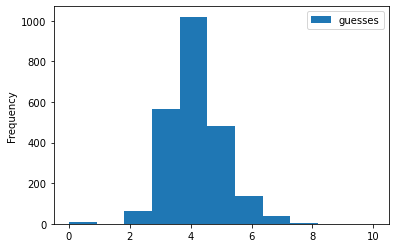

In [157]:
df = pd.DataFrame(solution_test_results, index=['guesses']).T
df.plot.hist(bins=df['guesses'].max()+1)

In [159]:
df.query('guesses == 0')

,guesses
agora,0
pupal,0
lynch,0
fibre,0
slave,0
wench,0
dont,0
repost,0


In [175]:
# Strange - a few of them weren't in the allowed words!
'slave' in allowed_words[0].values

False

In [179]:
print(len(df))
print(1 - len(df.query('(guesses > 6) | (guesses == 0)')) / len(df))
df.query('guesses > 6')

2317
0.9771255934397929


,guesses
wooer,10
goner,8
hatch,7
surer,7
ferry,7
swill,7
gawky,7
sever,7
stalk,7
cramp,7


In [176]:
a = [set(az) for _ in range(5)]
b = set()
test_solver('hound', a, b, verbose=True)


12947 valid words.

Frequent letters in common positions):
       Information Gain
tares          0.953709
lares          0.943887
cares          0.935361
pares          0.932017
dares          0.931812

Most common words:
       Word Frequency
about        1.000000
other        0.797631
which        0.660709
their        0.638157
there        0.571575

Weighted combination (w_info=1.0, w_freq=0.0):
       Combined Score  Information Gain  Word Frequency
word                                                   
tares         12946.0          0.953709        0.000058
lares         12945.0          0.943887        0.000054
cares         12944.0          0.935361        0.003878
pares         12943.0          0.932017        0.000111
dares         12942.0          0.931812        0.000429

Recommended word:
tares

00000

856 valid words.

Frequent letters in common positions):
       Information Gain
doily          0.553119
noily          0.546249
colin          0.534056
poind          0.5

8